# Convolutional Neural Network

**Notes about this specific notebook**

Uses rgb, 64x64 images with ReLU activation and Adam optimizer. No class or sample specific weights are used

# Changeable Parameters

_____________________________________________________________________

In [517]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'grayscale'

# Batch size
batch_size = 40000

# Number of epochs
epoch_t = 50

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# Division of the training vs. test set 
test_size = 0.3

# number of folds
n_folds = 10

_____________________________________________________________________

In [518]:
# To check whether the right environment has been selected
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


Import the necessary libraries

In [519]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Check whether a, and which GPU is available for the computation

In [520]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [521]:
# Image size
im_si = (ih, iw)

# Convert the color channel to the corresponding number of layers
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files if computation is done locally

In [522]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/malimg_dataset/"
    for files in os.listdir(dir):
        if "crossv-cnn" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: cnn-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/malimg_dataset/crossv-cnn-local-v{new_vnum:03}"
    os.makedirs(new_dir)

5 matches(es) found
--------------
New folder name: cnn-local-v006
--------------


**Data**


In [523]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"

if cenv == 1:
    path_root = "C:/Users/Max/Documents/image_data/malimg_paper_dataset_imgs/"

Load the data. No data augmentation takes place

In [524]:
batches = ImageDataGenerator().flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs, labels = next(batches)

Found 9339 images belonging to 25 classes.


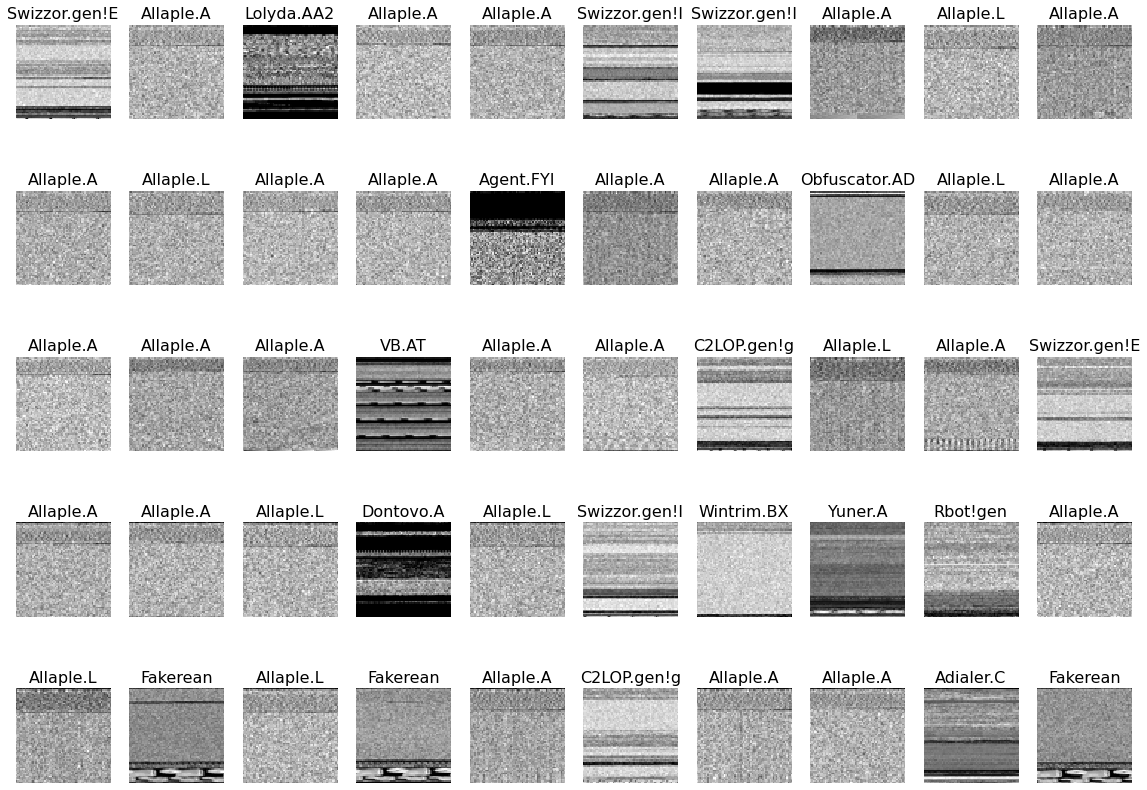

In [525]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs, titles = labels)

In [526]:
# A dictionary of all the different classes
classes = batches.class_indices.keys()
x = np.arange(len(list(classes)))

Plot data distribution among all classes

Standardize images

In [527]:
imgs = imgs / 255.0

Plot data distribution among train, val. and test set

# Convolutional Neural Network
We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, ReLU activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64 * 64 * 1

In [528]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold

In [529]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

We want **11** classes

In [530]:
num_classes = len(list(batches.class_indices))
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  25


Building the model

Reduce learning rate after 5 epochs of no improvement on the validition accuracy. Also save save checkpoints for the best performing model based on validation loss

In [531]:
def malware_model():
        Malware_model = Sequential()
        Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=(ih,iw,chnum)))

        Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
        Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
        Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
        Malware_model.add(Dropout(0.25))
        Malware_model.add(Flatten())
        Malware_model.add(Dense(128, activation='relu'))
        Malware_model.add(Dropout(0.5))
        Malware_model.add(Dense(50, activation='relu'))
        Malware_model.add(Dense(num_classes, activation='softmax'))
        Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
        return Malware_model

In [532]:
def confusion_matrix_bin_model(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):

        df_cm = pd.DataFrame(
            confusion_matrix, index=class_names_bin, columns=class_names_bin, 
        )
        fig = plt.figure(figsize=figsize)
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

class_names_bin= ("ransomware", "benign")

In [533]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


In [534]:
# Performance metrics
multi_acc_per_fold = []
loss_per_fold = []
multi_f1_per_fold = []

bin_acc_per_fold = []
bin_tpr_per_fold = []
bin_f1_per_fold = []
bin_mcc_per_fold = []

tp = []
fp = []
fn = []
tn = []

y_pred = []
y_true = []

rw_count = []
bn_count = []

# History
history = []

# Data distribution
train_distr = []
test_distr= []

In [535]:
kfold = KFold(n_splits=n_folds, shuffle=True)

In [536]:
fold_no = 1

for train, test in kfold.split(imgs,labels):
    
    # Compile the CNN
    Malware_model = malware_model()
    
    # Run the CNN
    history.append(
        Malware_model.fit(
        imgs[train], 
        labels[train], 
        validation_data=(imgs[test], labels[test]), 
        epochs=epoch_t,
        callbacks = [anne, checkpoint]) # The actual computation of the CNN
    )
    
    # Generate generalization metrics
    scores = Malware_model.evaluate(imgs[test], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {Malware_model.metrics_names[0]} of {scores[0]}; {Malware_model.metrics_names[1]} of {scores[1]*100}%')
    multi_acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    # Create two 1D-arrays: one with the prediction per image of the model and one with the true labels
    y_pred = np.append(y_pred, np.argmax(Malware_model.predict(imgs[test]), axis=-1))
    y_true = np.append(y_true, np.argmax(labels[test], axis=1))
    
    y_pred2 = np.argmax(Malware_model.predict(imgs[test]), axis=-1)
    y_true2 = np.argmax(labels[test], axis=1)
    
    multi_f1_per_fold.append(f1_score(y_true2, y_pred2, average='macro'))
    
    train_distr.append((sum(labels[train])/labels[train].shape[0])*100)
    test_distr.append((sum(labels[test])/labels[test].shape[0])*100)
    

Epoch 1/50
263/263 [==============================] - 3s 11ms/step - loss: 1.5167 - accuracy: 0.5366 - val_loss: 0.4378 - val_accuracy: 0.8683

Epoch 00001: val_loss improved from inf to 0.43780, saving model to /Users/Max/Documents/GitHub/malimg_dataset/crossv-cnn-local-v006\model.h5
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.5099 - accuracy: 0.8478 - val_loss: 0.2057 - val_accuracy: 0.9475

Epoch 00002: val_loss improved from 0.43780 to 0.20568, saving model to /Users/Max/Documents/GitHub/malimg_dataset/crossv-cnn-local-v006\model.h5
Epoch 3/50
263/263 [==============================] - 2s 6ms/step - loss: 0.3271 - accuracy: 0.8980 - val_loss: 0.1354 - val_accuracy: 0.9475

Epoch 00003: val_loss improved from 0.20568 to 0.13542, saving model to /Users/Max/Documents/GitHub/malimg_dataset/crossv-cnn-local-v006\model.h5
Epoch 4/50
263/263 [==============================] - 2s 6ms/step - loss: 0.2556 - accuracy: 0.9190 - val_loss: 0.1367 - val_accuracy: 0

263/263 [==============================] - 1s 5ms/step - loss: 0.0914 - accuracy: 0.9697 - val_loss: 0.0847 - val_accuracy: 0.9700

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00026: val_loss did not improve from 0.06503
Epoch 27/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0852 - accuracy: 0.9713 - val_loss: 0.0843 - val_accuracy: 0.9668

Epoch 00027: val_loss did not improve from 0.06503
Epoch 28/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0781 - accuracy: 0.9731 - val_loss: 0.0803 - val_accuracy: 0.9711

Epoch 00028: val_loss did not improve from 0.06503
Epoch 29/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0755 - accuracy: 0.9735 - val_loss: 0.0749 - val_accuracy: 0.9722

Epoch 00029: val_loss did not improve from 0.06503
Epoch 30/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0768 - accuracy: 0.9743 - val_loss: 0.0977 - val_accuracy: 0.9657

Epoch 0

263/263 [==============================] - 1s 5ms/step - loss: 0.1918 - accuracy: 0.9372 - val_loss: 0.1275 - val_accuracy: 0.9615

Epoch 00006: val_loss did not improve from 0.06503
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.1795 - accuracy: 0.9392 - val_loss: 0.1334 - val_accuracy: 0.9668

Epoch 00007: val_loss did not improve from 0.06503
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.1808 - accuracy: 0.9413 - val_loss: 0.1050 - val_accuracy: 0.9711

Epoch 00008: val_loss did not improve from 0.06503
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.1648 - accuracy: 0.9446 - val_loss: 0.1196 - val_accuracy: 0.9722

Epoch 00009: val_loss did not improve from 0.06503
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.1446 - accuracy: 0.9522 - val_loss: 0.1055 - val_accuracy: 0.9732

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 0001


Epoch 00046: val_loss did not improve from 0.06503
Epoch 47/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0801 - accuracy: 0.9700 - val_loss: 0.0923 - val_accuracy: 0.9764

Epoch 00047: val_loss did not improve from 0.06503
Epoch 48/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0782 - accuracy: 0.9713 - val_loss: 0.0932 - val_accuracy: 0.9764

Epoch 00048: val_loss did not improve from 0.06503
Epoch 49/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0756 - accuracy: 0.9731 - val_loss: 0.0939 - val_accuracy: 0.9764

Epoch 00049: val_loss did not improve from 0.06503
Epoch 50/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0798 - accuracy: 0.9711 - val_loss: 0.0945 - val_accuracy: 0.9797

Epoch 00050: val_loss did not improve from 0.06503
Score for fold 4: loss of 0.09447525441646576; accuracy of 97.96574115753174%
Epoch 1/50
263/263 [==============================] - 2s 6ms/step - loss: 1.4778 - accurac

263/263 [==============================] - 1s 5ms/step - loss: 0.0729 - accuracy: 0.9741 - val_loss: 0.1103 - val_accuracy: 0.9679

Epoch 00037: val_loss did not improve from 0.06503
Epoch 38/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0757 - accuracy: 0.9716 - val_loss: 0.1109 - val_accuracy: 0.9690

Epoch 00038: val_loss did not improve from 0.06503
Epoch 39/50
263/263 [==============================] - 1s 6ms/step - loss: 0.0769 - accuracy: 0.9710 - val_loss: 0.1143 - val_accuracy: 0.9679

Epoch 00039: val_loss did not improve from 0.06503
Epoch 40/50
263/263 [==============================] - 2s 6ms/step - loss: 0.0733 - accuracy: 0.9739 - val_loss: 0.1121 - val_accuracy: 0.9679

Epoch 00040: val_loss did not improve from 0.06503
Epoch 41/50
263/263 [==============================] - 2s 6ms/step - loss: 0.0733 - accuracy: 0.9744 - val_loss: 0.1171 - val_accuracy: 0.9679

Epoch 00041: val_loss did not improve from 0.06503
Epoch 42/50
263/263 [================

263/263 [==============================] - 1s 6ms/step - loss: 0.0785 - accuracy: 0.9733 - val_loss: 0.0732 - val_accuracy: 0.9732

Epoch 00028: val_loss did not improve from 0.06503
Epoch 29/50
263/263 [==============================] - 1s 6ms/step - loss: 0.0824 - accuracy: 0.9717 - val_loss: 0.0753 - val_accuracy: 0.9754

Epoch 00029: val_loss did not improve from 0.06503
Epoch 30/50
263/263 [==============================] - 1s 6ms/step - loss: 0.0816 - accuracy: 0.9710 - val_loss: 0.0705 - val_accuracy: 0.9754

Epoch 00030: val_loss did not improve from 0.06503
Epoch 31/50
263/263 [==============================] - 1s 6ms/step - loss: 0.0831 - accuracy: 0.9714 - val_loss: 0.0702 - val_accuracy: 0.9711

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00031: val_loss did not improve from 0.06503
Epoch 32/50
263/263 [==============================] - 1s 6ms/step - loss: 0.0812 - accuracy: 0.9722 - val_loss: 0.0729 - val_accuracy: 0.9732

Epoch 0

263/263 [==============================] - 2s 6ms/step - loss: 0.1090 - accuracy: 0.9624 - val_loss: 0.0828 - val_accuracy: 0.9732

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00019: val_loss did not improve from 0.06503
Epoch 20/50
263/263 [==============================] - 1s 6ms/step - loss: 0.0984 - accuracy: 0.9664 - val_loss: 0.0851 - val_accuracy: 0.9743

Epoch 00020: val_loss did not improve from 0.06503
Epoch 21/50
263/263 [==============================] - 1s 6ms/step - loss: 0.0944 - accuracy: 0.9672 - val_loss: 0.0834 - val_accuracy: 0.9722

Epoch 00021: val_loss did not improve from 0.06503
Epoch 22/50
263/263 [==============================] - 1s 6ms/step - loss: 0.0872 - accuracy: 0.9693 - val_loss: 0.0775 - val_accuracy: 0.9711

Epoch 00022: val_loss did not improve from 0.06503
Epoch 23/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0862 - accuracy: 0.9698 - val_loss: 0.0722 - val_accuracy: 0.9754

Epoch 0


Epoch 00048: val_loss did not improve from 0.06387
Epoch 49/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0578 - accuracy: 0.9799 - val_loss: 0.0800 - val_accuracy: 0.9797

Epoch 00049: val_loss did not improve from 0.06387
Epoch 50/50
263/263 [==============================] - 2s 6ms/step - loss: 0.0564 - accuracy: 0.9800 - val_loss: 0.0801 - val_accuracy: 0.9807

Epoch 00050: val_loss did not improve from 0.06387
Score for fold 8: loss of 0.08005046844482422; accuracy of 98.0728030204773%
Epoch 1/50
263/263 [==============================] - 2s 6ms/step - loss: 1.4648 - accuracy: 0.5654 - val_loss: 0.4196 - val_accuracy: 0.8812

Epoch 00001: val_loss did not improve from 0.06387
Epoch 2/50
263/263 [==============================] - 2s 6ms/step - loss: 0.4236 - accuracy: 0.8731 - val_loss: 0.2264 - val_accuracy: 0.9283

Epoch 00002: val_loss did not improve from 0.06387
Epoch 3/50
263/263 [==============================] - 1s 6ms/step - loss: 0.2753 - accuracy: 


Epoch 00029: val_loss did not improve from 0.06387
Epoch 30/50
263/263 [==============================] - 1s 6ms/step - loss: 0.0824 - accuracy: 0.9716 - val_loss: 0.0876 - val_accuracy: 0.9732

Epoch 00030: val_loss did not improve from 0.06387
Epoch 31/50
263/263 [==============================] - 1s 6ms/step - loss: 0.0828 - accuracy: 0.9706 - val_loss: 0.0856 - val_accuracy: 0.9711

Epoch 00031: val_loss did not improve from 0.06387
Epoch 32/50
263/263 [==============================] - 2s 6ms/step - loss: 0.0823 - accuracy: 0.9710 - val_loss: 0.0939 - val_accuracy: 0.9678

Epoch 00032: val_loss did not improve from 0.06387
Epoch 33/50
263/263 [==============================] - 1s 6ms/step - loss: 0.0782 - accuracy: 0.9706 - val_loss: 0.0878 - val_accuracy: 0.9700

Epoch 00033: val_loss did not improve from 0.06387
Epoch 34/50
263/263 [==============================] - 1s 5ms/step - loss: 0.0856 - accuracy: 0.9705 - val_loss: 0.0923 - val_accuracy: 0.9700

Epoch 00034: val_loss di

Run the model

In [537]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(multi_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {multi_acc_per_fold[i]*100}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(multi_acc_per_fold)*100}% (+- {np.std(multi_acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.06934604048728943 - Accuracy: 97.43040800094604%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0827508345246315 - Accuracy: 97.32334017753601%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.09209970384836197 - Accuracy: 97.64453768730164%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.09447525441646576 - Accuracy: 97.96574115753174%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.10940855741500854 - Accuracy: 97.00214266777039%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.07150209695100784 - Accuracy: 97.64453768730164%
-------------------------------------------------------------------

# Evaluating performance

Create data distribution graph

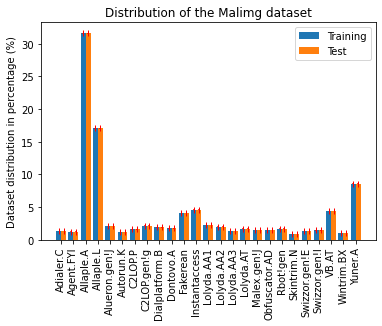

In [538]:
perc_train = np.mean(train_distr, axis = 0)
perc_test =  np.mean(test_distr, axis = 0)

plt.bar(x - 0.2, perc_train, 0.4, label = 'Training')
plt.errorbar(x - 0.2, perc_train, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize = 0)

plt.bar(x + 0.2, perc_test,0.4, label = 'Test')
plt.errorbar(x + 0.2, perc_test, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize=0.0)


plt.title('Distribution of the Malimg dataset')
plt.ylabel('Dataset distribution in percentage (%)')
plt.xticks(x, list(classes), rotation='vertical')
plt.legend()

if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight', dpi = 150)

In [539]:
t = PrettyTable(['Metric', 'Performance', 'St.Deviation'])
t.add_row(['M-Class', "", ""])
t.add_row(['Acc    ', round(np.mean(multi_acc_per_fold),4), round(np.std(multi_acc_per_fold),4)])
t.add_row(['Loss   ', round(np.mean(loss_per_fold),4), round(np.std(loss_per_fold),4)])
t.add_row(['Macro F1     ', round(np.mean(multi_f1_per_fold),4), round(np.std(multi_f1_per_fold),4)])
t.border = True
t.header = True
t.set_style(MSWORD_FRIENDLY)
t.align = "l"
t.title = "Performance of CNN on Malimg"
print(t)

+--------------------------------------------+
|        Performance of CNN on Malimg        |
| Metric        | Performance | St.Deviation |
| M-Class       |             |              |
| Acc           | 0.9745      | 0.0045       |
| Loss          | 0.0879      | 0.0155       |
| Macro F1      | 0.9199      | 0.0091       |


In [540]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

Evaluate the model based on the test set

Save a table with the performance on the test set

**Evaluating overfitting and other model performance measures**

In [541]:
linecolours = ['gray', 'orange', 'blue', 'green','silver', 'cyan', 'red', 'purple', 'lightgreen', 'black', 'brown']

In [542]:
def eval_metric(model, history, metric_name, ymin, ymax):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    for i in range(n_folds-1):  
        metric = history[i].history[metric_name]
        val_metric = history[i].history['val_' + metric_name]
        e = range(1, epoch_t + 1)
        plt.plot(e, metric, marker = 'o', linestyle = 'none', color = linecolours[i])
        plt.plot(e, val_metric, color = linecolours[i])
        
    metric = history[n_folds-1].history[metric_name]
    val_metric = history[n_folds-1].history['val_' + metric_name]
    e = range(1, epoch_t + 1)
    plt.plot(e, metric, marker = 'o', linestyle = 'none', label = 'Training', color = linecolours[n_folds-1])
    plt.plot(e, val_metric, label = 'Validation', color = linecolours[n_folds-1])
    
    plt.ylim(ymin, ymax)
    
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for CNN across folds')
    plt.legend()
    if cenv == 0:
        plt.savefig(f"cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)

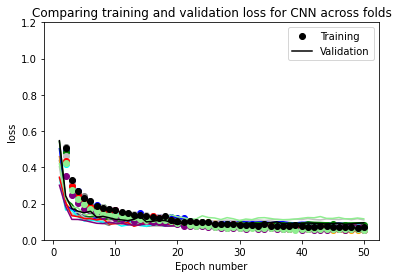

In [543]:
eval_metric(Malware_model, history, 'loss', 0, 1.2)

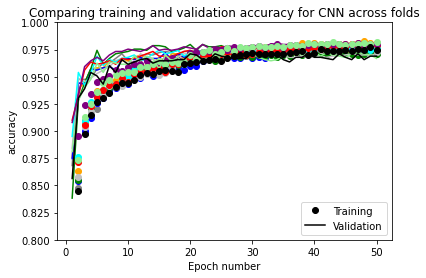

In [544]:
eval_metric(Malware_model, history, 'accuracy', 0.8, 1)

**Confusion Matrix**

In [545]:
c_matrix = metrics.confusion_matrix(y_true, y_pred)
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if cenv == 0:
        plt.savefig("multi_class_cmatrix.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/multi_class_cmatrix.png", bbox_inches = 'tight', dpi = 150)

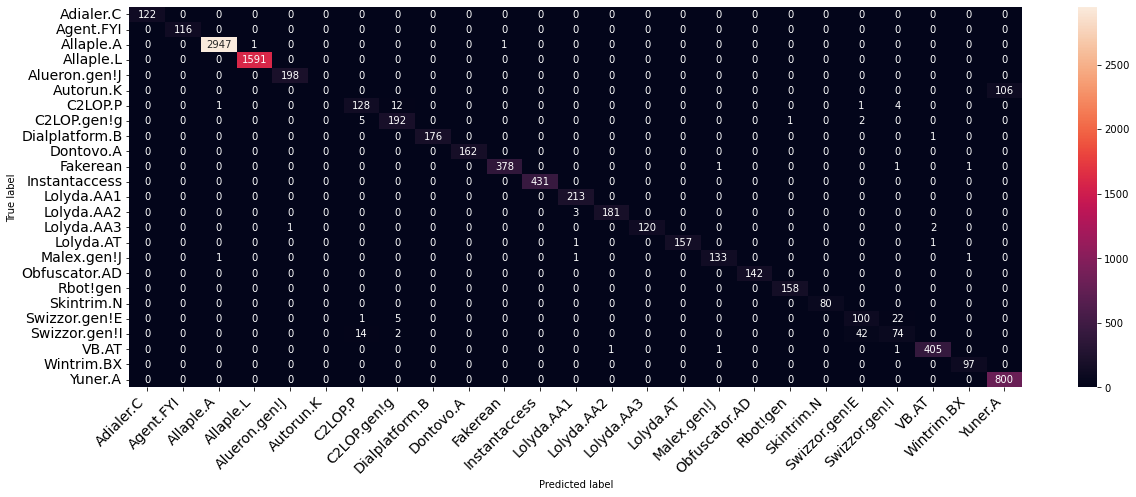

In [546]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)